# Classifying seismic receiver functions using logistic regression

In this lab exercise, your task is to classify seismic receiver functions into two categories: good and bad. The bad seismic traces, in practice, are excluded from all further analysis. And only good seismic traces are kept for the subsequent quantitative analysis. To perform classification, you will implement logistic regression using Scikit-learn package. Specifically, you are going to use the [logistic regression](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html) module by importing it from [Scikit-Learn](https://scikit-learn.org/stable/). <br>
<br>
After finishing this exercise, you will understand: <br>
- How to implement logistic regression using Scikit-Learn; <br>
- The typical data preprocessing steps involved in many machine learning implementation; <br>
- How to evaluate a learned model; <br>
- How the learning errors of training and validation sets change as the size of training data set increases. <br>
<br>

You will also see that machine learning can significantly accelerate the classification problem from manual labeling that takes weeks to automatic labeling that takes about 20 seconds. <br>
<br>
Author: Jiajia Sun, 02/07/2019 at University of Houston.

# 1. Introduction to USArray data
The seismic data we are going to use for this lab exercise was recorded by USArray Transportable Array (TA). The TA has traversed the continental United States and collected voluminous amounts of broadband seismic data that contain extremely rich information for mapping the structures of the Earth’s interior underneath North America. It is currently being deployed in Alaska.

Here is a picutre summarizing the locations of current USArray TA seismic receivers.
<img src="TA_AK.png">

The data we are going to classify is actually the P-wave receiver functions that were computed based on raw seismic data. P-wave receiver functions are widely used in crustal studies, because they provide important information about the crustal thickness. The seismological data used in our study are from earthquakes with a distance range of $30^\circ$ to $90^\circ$ and a magnitude of Mb 5 and above recorded at 201 stations in Alaska from the TA and Alaska Regional Network. 12,597 receiver function traces were obtained, and manually labeled ‘good’ or ‘bad’.

To learn more about USArray data, please refer to the following resources: <br>
1\. http://www.usarray.org/researchers/dataas  <br>
2\. http://ds.iris.edu/ds/nodes/dmc/earthscope/usarray/ <br>
3\. http://www.usarray.org/Alaska <br>
<br>
For more information on receiver functions, please refer to the following materials: <br>
1\. https://ds.iris.edu/media/workshop/2013/01/advanced-studies-institute-on-seismological-research/files/lecture_introrecf.pdf <br>
2\. http://www.diss.fu-berlin.de/diss/servlets/MCRFileNodeServlet/FUDISS_derivate_000000001205/3_Chapter3.pdf?hosts= <br>
<br>
Note that, for the purpose of this class, you do not need to know anything about seismology or receiver functions.

# 2. Import data

The following code imports the data from Traces_qc.mat.

In [2]:
!pip install numpy h5py

    100% |████████████████████████████████| 17.3MB 169kB/s eta 0:00:01   13% |████▍                           | 2.4MB 43.1MB/s eta 0:00:01
    100% |████████████████████████████████| 2.8MB 1.3MB/s eta 0:00:01


In [5]:
!pip install download

    100% |████████████████████████████████| 51kB 5.9MB/s ta 0:00:01


In [14]:
!pip install matplotlib

    100% |████████████████████████████████| 12.9MB 227kB/s eta 0:00:01
    100% |████████████████████████████████| 71kB 18.6MB/s ta 0:00:01
    100% |████████████████████████████████| 952kB 3.2MB/s eta 0:00:01


In [19]:
!pip install sklearn

    100% |████████████████████████████████| 5.4MB 650kB/s eta 0:00:01
    100% |████████████████████████████████| 26.6MB 134kB/s eta 0:00:01
  Stored in directory: /home/jovyan/.cache/pip/wheels/76/03/bb/589d421d27431bcd2c6da284d5f2286c8e3b2ea3cf1594c074
Successfully built sklearn


In [6]:
from download import download

In [9]:
url = "https://www.dropbox.com/s/sjqwbmr0bqc93fb/Traces_qc.mat?dl=0"
path = download(url, './downloaded/Traces_qc.mat', replace=True)

Successfully downloaded file to ./downloaded/Traces_qc.mat


In [11]:
import numpy as np
import h5py
with h5py.File("./downloaded/Traces_qc.mat") as f:
    ampdata = [f[element[0]][:] for element in f["Data"]["amps"]]
    flag = [f[element[0]][:] for element in f["Data"]["Flags"]]
    ntr = [f[element[0]][:] for element in f["Data"]["ntr"]]
    time = [f[element[0]][:] for element in f["Data"]["time"]]
    staname = [f[element[0]][:] for element in f["Data"]["staname"]]

In [12]:
ampall = np.zeros((1,651))
flagall = np.zeros(1)
for i in np.arange(201):
    ampall = np.vstack((ampall, ampdata[i]))
    flagall = np.vstack((flagall, flag[i]))
amp_data = np.delete(ampall, 0, 0)
flag_data = np.delete(flagall, 0, 0)

The **amp_data** stores the seismic amplitudes from all seismic stations. The **flag_data** contains the labels for each seismic traces. These labels are encoded as 1s and 0s, with 0 representing bad seismic traces, and 1 corresponding good seismic traces. Recall that, logistic regression is a supervised machine learning, and therefore, it requires labels. Also recall that, logistic regression is a binary classification algorithm, and the labels are most often expressed numerically as 0s and 1s. 

Now, let us plot up a few 'good' seismic traces which are all labeled as 1s.

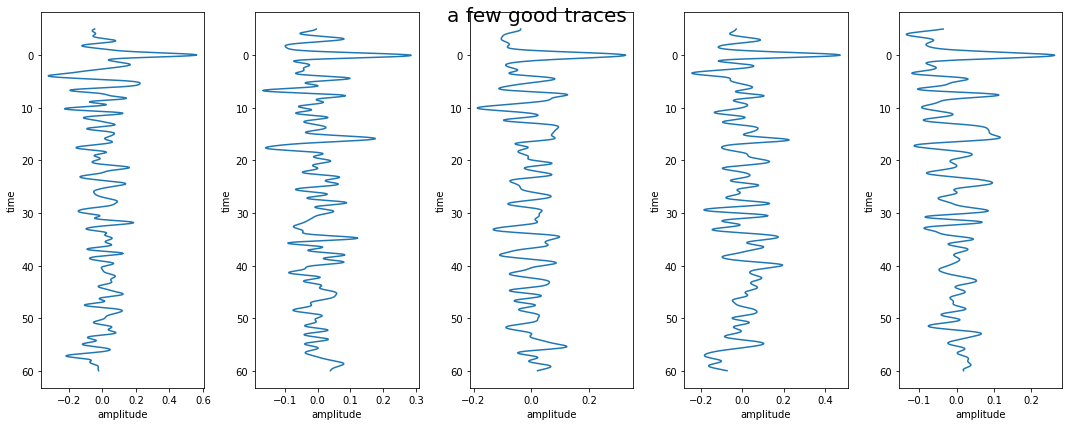

In [16]:
goodtraceindex = np.nonzero(flag_data)[0].reshape(-1,1)
# plot a few good traces (before scaling is applied)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1,5, figsize=(15, 6), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
fig.suptitle('a few good traces', fontsize=20)

axs = axs.ravel()
ic = 0
for icount in goodtraceindex[:5,0]:       
              
    axs[ic].plot(amp_data[icount,:], time[0])
    axs[ic].invert_yaxis()
    axs[ic].set_xlabel('amplitude')
    axs[ic].set_ylabel('time')
        
    ic = ic + 1
        
# tight_layout() will also adjust spacing between subplots to minimize the overlaps    
plt.tight_layout()      
plt.show()       

There are a few obvious features that are common to all 'good' traces. First, there is a distinct peak at time 0. Second, there is a second peak around 5 seconds. (This actually provides information about the crustal thickness). Thirdly, the amplitude for the peak at time 0 should be clearly higher than that for the second peak.
<br>

<font color = red>**Note**</font>: Visualzing data and getting an intuitive understanding of your data is very important. It is almost always done in practice. This is the first step to getting to know your data. Other ways of knowing your data better include summarizing your data using statistics such as max/min, mean, variance, quantile, histogram, etc.

# 3. Preprocessing (i.e., preparing data for subsequent machine learning)

One common preprocessing step is to normalize your data so that they have a mean of 0 and a standard deviation of 1. The reasons for doing this are twofold. First, for practical machine learning problems, different features have different scales. For example, when it comes to predicting life satisfaction, the GPD per capita might be on the order of ~1000s, whereas the education system might be ranked on a scale of 0 to 1, with 1 representing the best education. It turns out, features with vastly different scales make the optimization biased toward the ones that have large values (e.g., GPD per capita instead of education system). Secondly, for minimization, the shape of the cost function associated with features of different scales becomes elongated, making the gradient descent type of algorithms less efficient. <br>
<br>
Therefore, normalizing data is very commonly done in practice.

The following code shows how the scaling (or, normalizing) is typically done using Scikit-learn. 

In [20]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler().fit(amp_data)
scaled_ampdata = scaler.transform(amp_data)

In [21]:
# To find out how many traces are labled as 'bad'
scaled_ampdata[np.where(flag_data == 0)[0],:].shape[0]

9632

In [22]:
# to find out how many traces are labeled as 'good'
scaled_ampdata[np.nonzero(flag_data)[0],:].shape[0]

2965

In [23]:
# Total number of seismic traces
scaled_ampdata.shape[0]

12597

Next, we need to randomly permute these data before we start doing machine learning. The reason for doing this is to avoid the situation where your training data are ordered in some specific way. For example, it might happen that all the good seismic traces are together, followed by all the bad traces. If we are not careful, our training data set might be all the good seismic traces, and our validation or test data set might be all the bad ones. This is very dangerous because your machine lerning algorithm will not have any chance of learning from the bad seismic traces at the training stage, and you can expect that no matter how you train a machine learning model, it will not predict well on the validation/test data. Randomly permuting the data will ensure that the training set contains data from every category (good and bad), and validation/test set also contains data from all categories. 

In [24]:
np.random.seed(42)
whole_data = np.append(scaled_ampdata,flag_data,1) # put all the seismic traces and their lables into one matrix which contain the whole data set for subsequent machine learing.
training_data_permute = whole_data[np.random.permutation(whole_data.shape[0]),:] 

# 4. Split the data into training and validation sets
<font color = red>**Task 1**</font>: Please write a few sentences here to explain why we do this. <font color = red>**(10 points)**</font>

In [ ]:
<answer to Task 1:>
    

We are going to use the first 2000 seismic traces and their corresponding labels as our training data set.

In [ ]:
X_train = training_data_permute[0:2000,:-1]
y_train = training_data_permute[0:2000,-1]

Similarly, we are going to put aside the seismic traces with indices from 10000 to the very end as our validation (or test) data set.

In [ ]:
X_validation = training_data_permute[10000:,:-1]
y_validation = training_data_permute[10000:,-1]

# 5. Implementing logistic regression using Scikit-learn

<font color = red>**Task 2:**</font> Please import the logistic regression module from Scikit-learn. <font color = red>**(10 points)**</font> <br>
<br>
**HINT:** If you forget how to do it, please refer back to <fontn color=blue>Lab3_LogisticRegression_example.ipynb</font>.

<font color = red>**Task 3**</font>: Assign the LogisticRegression method to a new variable *log_reg*. <font color = red>**(10 points)**</font> 

**HINT**: Please refer back to Lab3_LogisticRegression_example.ipynb. Note that, in Lab3_LogisticRegression_example.ipynb, I set C = 10$^{10}$. However, for this exercise, please use the default value for C that comes with the logistic regression module that you just imported. That is, instead of using LogisticRegression(C=10**10, random_state=42), you should use LogisticRegression(random_state=42)

<font color = red>**Task 4:**</font> Train a logistic regession model using our training data, i.e., X_train and y_train. <font color = red> **(10 points)**</font>

**HINT:** Again, if you do not know how to do it, please take a look at Lab3_LogisticRegression_example.ipynb. Only one line of code is necessary for this task.

# 6. Evaluation of the learned logistic regression model

<font color = red>**Task 5:**</font> Output the accuracy (or score) of the predictions on the **training** data set. <font color = red>**(10 points)**</font>

**HINT**: Please refer to Lab3_LogisticRegression_example.ipynb, if you are not sure what to do.

<font color = red>**Task 6:**</font> Output the accuracy (or score) of the predictions on the **validation** data set. <font color = red>**(10 points)**</font>

**HINT**: Please refer to Lab3_LogisticRegression_example.ipynb, if you are not sure what to do.

<font color = red>**Task 7:**</font> Output the error of the predictions on both the **training** and **validation** data sets. <font color = red>**(5 points)**</font>

**HINT**: error = 1 - accuracy, where accuracy is what you just obtained in Task 5 and 6.

# 7. Constructing error curves

<font color = red>**Task 8:**</font> So far, we have only used 2,000 seismic traces as our training data set. But remember that we can use up to 10,000 traces as our training data set (the remaining 2,597 traces were reserved for validation). For this task, create a training data set with 4000 seismic traces (do not touch the validation data set that we set previously). And 
compute the errors of the predictions on both training and validation data sets. Similary, create a training data set with 6000, 8000 and 10000 seismic traces, and compute their respective errors on both training and validation data sets. <font color = red>**(30 points)**</font>

**HINT:** To create a training data set with 4000 seismic traces, you can use the following codes: <br>
X_train = training_data_permute[0:4000,:-1] <br>
y_train = training_data_permute[0:4000,-1] <br>
<br>
**NOTE:** For this task, our validation data set is always the same as before, that is: <br>
X_validation = training_data_permute[10000:,:-1] <br>
y_validation = training_data_permute[10000:,-1] <br>
<br>
You do not need to do anything with the validation data set.

<font color = red>**Task 9:**</font> Store the errors of the predictions on **training** data using 2000, 4000, 6000, 8000, and 10000 seismic traces in a Numpy array **train_errors**. Similarly, store the errors of the predictions on **validation** data using 2000, 4000, 6000, 8000, and 10000 seismic traces in a Numpy array **validation_errors**. <font color = red>**(5 points)**</font> <br>
<br>
**HINT:** Your **train_errors** should look like this: train_errors = np.array([0.169, 0.17825, 0.17966667, 0.180875, 0.1827]). And your **validation_errors** should look similar (the values in the array might be different though).

Now let us plot up the error curves.

In [ ]:
trainingsize =  np.array([2000,4000,6000,8000,10000])
plt.plot(trainingsize,train_errors,'-ro',label="training errors")
plt.plot(trainingsize,validation_errors,'-bo',label="validation errors")
plt.title('Learning curves',fontsize=20)
plt.legend(loc="lower right", fontsize=16)
plt.xlabel("Size of training data", fontsize=20)
plt.ylabel("Prediction error", fontsize=20, rotation=90)
plt.show()

**BONUS:** Summarize the change of training and validation errors as the size of the training data increases. Explain it. <font color=red>**(10 points)**</font>

# Acknowledgments
I would like to thank Ying Zhang for manually labeling all the seismic traces, and Prof. Aibing Li for making this data set available to the students in this class. Ms. Zhang also kindly explained the fundamentals of seismic P-wave receiver functions to a non-seismic person (yes, that is me!) <br>

<img src = "photo.png">

# Congratulations! You have now mastered a great skill that allows you to classify things into binary classes using logistic regression. You have also started to use Scikit-learn to do machine learning. You have achieved a lot!